This script is meant to contain a bunch of timeseries diagrams that show how certain variables are changing over time. At the moment it is very messy due to some... experimentation with the best way to protry these time series given the disperse sampling time of the Wade and CTD data. Hopefully, we can acquire some moore data that will allow for the formation of more detailed timeseries. This notebook will allow for multiple years to e viewed easily. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import netCDF4 as nc
import datetime as dt
from salishsea_tools import evaltools as et, viz_tools
import gsw 
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import matplotlib.dates as mdates
import cmocean as cmo
import scipy.interpolate as sinterp
import pickle
import cmocean
import json
import f90nml
import xarray as xr
import datetime as dt
from collections import OrderedDict

fs=16
mpl.rc('xtick', labelsize=fs)
mpl.rc('ytick', labelsize=fs)
mpl.rc('legend', fontsize=fs)
mpl.rc('axes', titlesize=fs)
mpl.rc('axes', labelsize=fs)
mpl.rc('figure', titlesize=fs)
mpl.rc('font', size=fs)
mpl.rc('font', family='sans-serif', weight='normal', style='normal')

import warnings
#warnings.filterwarnings('ignore')
from IPython.display import Markdown, display

%matplotlib inline

In [2]:
years=[2015,2016,2017]
PATH= '/results2/SalishSea/nowcast-green.201905/'
datadir='/ocean/eolson/MEOPAR/obs/WADE/ptools_data/ecology'

In [3]:
display(Markdown('''## Years: '''+ str(years)))

## Years: [2015, 2016, 2017]

In [4]:
display(Markdown('''### Model output: '''+ PATH))

### Model output: /results2/SalishSea/nowcast-green.201905/


## Yearly model-data comparisons of nutrients, chlorophyll, temperature and salinity between 201905 runs and WADE observations

### load observations

In [5]:
dfSta=pickle.load(open(os.path.join(datadir,'sta_df.p'),'rb'))

In [6]:
dictBot={}
for i in years:
    dictBot[i]=pickle.load(open(os.path.join(datadir,f'Bottles_{str(i)}.p'),'rb'))

In [7]:
dfBot=pd.concat(dictBot.values(), ignore_index=True)

In [8]:
df1=pd.merge(left=dfSta,right=dfBot,how='right',
             left_on='Station',right_on='Station')
#right join means all rows in right table (dfBot) are included in output

In [9]:
# check that there are no stations without lat and lon:
df1.loc[pd.isnull(df1['Latitude'])]

,Station,Desig,Descrip,Basin,Max_Depth,Latitude,Longitude,Date,UTCDateTime,Z,PO4(uM)D,SiOH4(uM)D,NO3(uM)D,NO2(uM)D,NH4(uM)D,DIN,Znom


In [10]:
# check one to one matches:
len(df1),len(dfBot), len(dfSta)

(2674, 2674, 39)

In [11]:
# where no time is provided, set time to midday Pacific time = ~ 20:00 UTC for now
# (most sampling takes place during the day)
# accurate times will be provided at a later date
# the code below takes advantage of all elements in 'Date' having a time component 
# set to midnight
df1['UTCDateTime']=[iiD+dt.timedelta(hours=20) if pd.isnull(iiU) \
                    else iiU for iiU,iiD in \
                    zip(df1['UTCDateTime'],df1['Date'])]

In [12]:
# We require the following columns:
#    dtUTC datetime
#    Lat   Latitude
#    Lon   Longitude
#    Z     Depth, increasing downward (positive)
df1.rename(columns={'UTCDateTime':'dtUTC','Latitude':'Lat','Longitude':'Lon'},inplace=True)
df1['Z']=-1*df1['Z']

In [13]:
# It will also be useful to add/rename the following columns:
df1['NO23']=df1['NO3(uM)D']+df1['NO2(uM)D'] # the model does not distinguish between NO2 and NO3
df1['Amm']=df1['NH4(uM)D']
df1['Si']=df1['SiOH4(uM)D']
df1['Year']=[ii.year for ii in df1['dtUTC']]
df1['YD']=et.datetimeToYD(df1['dtUTC'])

## load CTD data and add CT and SA to nutrient data set

In [14]:
dictCTD=dict()
for i in years:
    dictCTD[i]=pickle.load(open(os.path.join(datadir,f'Casts_{str(i)}.p'),'rb'))
dfCTD0=pd.concat(dictCTD.values(), ignore_index=True)
dfCTD=pd.merge(left=dfSta,right=dfCTD0,how='right',
             left_on='Station',right_on='Station')
dfCTD['dtUTC']=[iiD+dt.timedelta(hours=20) for iiD in dfCTD['Date']] 
dfCTD.rename(columns={'Latitude':'Lat','Longitude':'Lon'},inplace=True)
dfCTD['Z']=-1*dfCTD['Z']
# Calculate Absolute (Reference) Salinity (g/kg) and Conservative Temperature (deg C) from 
# Salinity (psu) and Temperature (deg C):
press=gsw.p_from_z(-1*dfCTD['Z'],dfCTD['Lat'])
dfCTD['SA']=gsw.SA_from_SP(dfCTD['Salinity'],press,
                           dfCTD['Lon'],dfCTD['Lat'])
dfCTD['CT']=gsw.CT_from_t(dfCTD['SA'],dfCTD['Temperature'],press)

dfCTD['Year']=[ii.year for ii in dfCTD['dtUTC']]
dfCTD['YD']=et.datetimeToYD(dfCTD['dtUTC'])

In [15]:
# check that there is never more than one ctd cast per station per day:
test=dfCTD.groupby(['Station','Year','YD','Z']).count()
print('this should be 1: ',test['Date'].unique())

this should be 1:  [1]


In [16]:
def interpCTDvar(sta,yr,yd,ztarget,ctdvar):
    ctdlocs=(dfCTD.Station==sta)&(dfCTD.Year==yr)&(dfCTD.YD==yd)
    if np.sum(ctdlocs)==0:
        print(f'Warning: Station {sta}, Year {yr}, year day {yd} not found in dfCTD')
        return np.nan
    else:
        val=np.interp(ztarget,dfCTD.loc[ctdlocs,['Z']].values.flatten(),
                  dfCTD.loc[ctdlocs,[ctdvar]].values.flatten())
        return val

In [17]:
dfCTD.loc[dfCTD.Station=='PSS019']['YD'].unique() # lets you view the different dates data was callected on.

array([ 21,  55,  83, 119, 166, 187, 223, 264, 327, 350,  25,  53,  82,
       109, 138, 188, 236, 256, 326,  54,  94, 129, 165, 199, 228, 296,
       341])

In [18]:
df1.loc[df1.Station=='PSS019']['YD'].unique()

array([ 21,  55,  83, 119, 166, 187, 223, 264, 327, 350,  25,  53,  82,
       109, 138, 188, 236, 256, 326,  54,  94, 129, 165, 199, 228, 296,
       341])

In [19]:
df1['SA']=[interpCTDvar(sta,yr,yd,ztarget,'SA') for sta, yr, yd, ztarget \
           in zip(df1['Station'],df1['Year'],df1['YD'],df1['Z'])]

In [20]:
df1['CT']=[interpCTDvar(sta,yr,yd,ztarget,'CT') for sta, yr, yd, ztarget \
           in zip(df1['Station'],df1['Year'],df1['YD'],df1['Z'])]

### set up variables for model-data matching

In [21]:
fdict={'ptrc_T':1,'grid_T':1}
# start_date and end_date are the first and last dates that will 
#  be included in the matched data set
start_date = dt.datetime(years[0],1,1)
end_date = dt.datetime(years[-1],12,31)
flen=1 # number of days per model output file. always 1 for 201905 and 201812 model runs
namfmt='nowcast' # for 201905 and 201812 model runs, this should always be 'nowcast'
# filemap is dictionary of the form variableName: fileType, where variableName is the name
# of the variable you want to extract and fileType designates the type of 
# model output file it can be found in (usually ptrc_T for biology, grid_T for temperature and 
# salinity)
filemap={'nitrate':'ptrc_T','silicon':'ptrc_T','ammonium':'ptrc_T','diatoms':'ptrc_T',
         'ciliates':'ptrc_T','flagellates':'ptrc_T','votemper':'grid_T','vosaline':'grid_T'}
# fdict is a dictionary mappy file type to its time resolution. Here, 1 means hourly output
# (1h file) and 24 means daily output (1d file). In certain runs, multiple time resolutions 
# are available
fdict={'ptrc_T':1,'grid_T':1}
# Note: to switch between 201812 and 201905 model results, change PATH
# to switch from hourly to daily model output, change fdict values from 1 to 24 (but daily 
#  files are not available for some runs and file types)

In [22]:
data=et.matchData(df1,filemap,fdict,start_date,end_date,'nowcast',PATH,1,quiet=False);

(Lat,Lon)= 46.453155 -124.00960333333333  not matched to domain
(Lat,Lon)= 46.463155 -123.94126833333334  not matched to domain
(Lat,Lon)= 46.54537666666667 -123.98016166666666  not matched to domain
(Lat,Lon)= 46.644 -123.993  not matched to domain
(Lat,Lon)= 46.68676333333333 -123.9735  not matched to domain
(Lat,Lon)= 46.703986666666665 -123.837385  not matched to domain
(Lat,Lon)= 46.937313333333336 -123.91322333333333  not matched to domain
(Lat,Lon)= 46.953421666666664 -124.09295  not matched to domain
(Lat,Lon)= 47.21342666666666 -123.07765  not matched to domain


In [23]:
cm1=cmocean.cm.thermal
with nc.Dataset('/data/eolson/results/MEOPAR/NEMO-forcing-new/grid/bathymetry_201702.nc') as bathy:
    bathylon=np.copy(bathy.variables['nav_lon'][:,:])
    bathylat=np.copy(bathy.variables['nav_lat'][:,:])
    bathyZ=np.copy(bathy.variables['Bathymetry'][:,:])

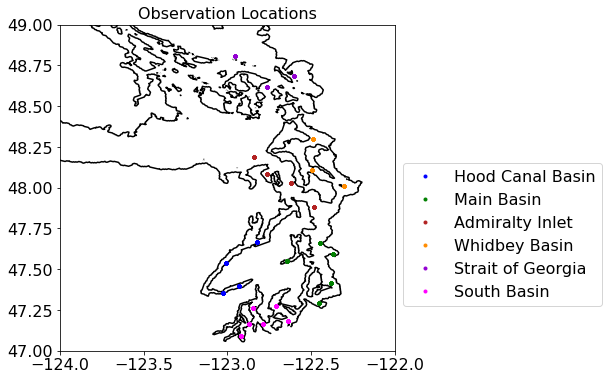

In [24]:
fig, ax = plt.subplots(1,1,figsize = (6,6))
with nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc') as grid:
    viz_tools.plot_coastline(ax, grid, coords = 'map',isobath=.1)
colors=('blue','green','firebrick','darkorange','darkviolet','fuchsia',
        'royalblue','darkgoldenrod','mediumspringgreen','deepskyblue')
datreg=dict()
for ind, iregion in enumerate(data.Basin.unique()):
    datreg[iregion] = data.loc[data.Basin==iregion]
    ax.plot(datreg[iregion]['Lon'], datreg[iregion]['Lat'],'.',
            color = colors[ind], label=iregion)
ax.set_ylim(47, 49)
ax.legend(bbox_to_anchor=[1,.6,0,0])
ax.set_xlim(-124, -122);
ax.set_title('Observation Locations');

iz=(data.Z<15)

# When working with multiple years, a for loop is necessary to split things up by months. 
JFMd=dict()
Aprd=dict()
MJJAd=dict()
SONDd=dict()
for i in years:
    JFMd[i]=data.loc[iz&(data.dtUTC<=dt.datetime(i,4,1)),:]
    Aprd[i]=data.loc[iz&(data.dtUTC<=dt.datetime(i,5,1))&(data.dtUTC>dt.datetime(i,4,1)),:]
    MJJAd[i]=data.loc[iz&(data.dtUTC<=dt.datetime(i,9,1))&(data.dtUTC>dt.datetime(i,5,1)),:]
    SONDd[i]=data.loc[iz&(data.dtUTC>dt.datetime(i,9,1)),:]
JFM=pd.concat(JFMd.values(), ignore_index=True)
Apr=pd.concat(Aprd.values(), ignore_index=True)
MJJA=pd.concat(MJJAd.values(), ignore_index=True)
SOND=pd.concat(SONDd.values(), ignore_index=True)

These two new dictionaries make it easier to call upon graphs for different years. 

In [25]:
datstat=dict()
for ind, istation in enumerate(data.Station.unique()):
    datstat[istation]=data.loc[data.Station == istation]
    
datyear=dict()
for ind, iyear in enumerate(data.dtUTC.dt.year.unique()):
    datyear[iyear] = data.loc[data.dtUTC.dt.year==iyear]
    
datyearreg=dict()
for iyear in datyear:
    datyearreg[iyear]=dict()
    for iregion in datyear[iyear].Basin.unique():
        datyearreg[iyear][iregion]=datyear[iyear].loc[datyear[iyear].Basin==iregion]

In [26]:
def byDepth(ax,obsvar,modvar,lims,byyear = False,year = 'NA'):
    if byyear == False:
        ps=et.varvarPlot(ax,data,obsvar,modvar,'Z',(15,22),'z','m',('mediumseagreen','darkturquoise','navy'))
        l=ax.legend(handles=ps)
    elif byyear == True:
        ps=et.varvarPlot(ax,datyear[year],obsvar,modvar,'Z',(15,22),'z','m',('mediumseagreen','darkturquoise','navy'))
        l=ax.legend(handles=ps)
    ax.set_xlabel('Obs')
    ax.set_ylabel('Model')
    ax.plot(lims,lims,'k-',alpha=.5)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_aspect(1)
    return ps,l

def byRegion(ax,obsvar,modvar,lims,year):
    ps=[]
    for ind, iregion in enumerate(data[data.dtUTC.dt.year==year].Basin.unique()):
        ax.plot(datyearreg[year][iregion]['Lon'], datyearreg[year][iregion]['Lat'],'.',
                color = colors[ind], label=iregion)
        ps0=et.varvarPlot(ax,datyearreg[year][iregion],obsvar,modvar,
                        cols=(colors[ind],),lname=iregion)
        ps.append(ps0)
    l=ax.legend(handles=[ip[0][0] for ip in ps])
    ax.set_xlabel('Obs')
    ax.set_ylabel('Model')
    ax.plot(lims,lims,'k-',alpha=.5)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_aspect(1)
    return ps,l

def byStation(ax,obsvar,modvar,lims,region):
    ps=[]
    for ind, istation in enumerate(data[data['Basin'] == region].Station.unique()):
        ax.plot(datstat[istation]['Lon'], datstat[istation]['Lat'],'.',
                    color = colors[ind], label=istation)
        ps0=et.varvarPlot(ax,datstat[istation],obsvar,modvar,
                            cols=(colors[ind],),lname=istation)
        ps.append(ps0)
    l=ax.legend(handles=[ip[0][0] for ip in ps])
    ax.set_xlabel('Obs')
    ax.set_ylabel('Model')
    ax.plot(lims,lims,'k-',alpha=.5)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_aspect(1)
    return ps,l

def bySeason(ax,obsvar,modvar,lims):
    for axi in ax:
        axi.plot(lims,lims,'k-')
        axi.set_xlim(lims)
        axi.set_ylim(lims)
        axi.set_aspect(1)
        axi.set_xlabel('Obs')
        axi.set_ylabel('Model')
    ps=et.varvarPlot(ax[0],JFM,obsvar,modvar,cols=('crimson','darkturquoise','navy'))
    ax[0].set_title('Jan-Mar')
    ps=et.varvarPlot(ax[1],Apr,obsvar,modvar,cols=('crimson','darkturquoise','navy'))
    ax[1].set_title('Apr')
    ps=et.varvarPlot(ax[2],MJJA,obsvar,modvar,cols=('crimson','darkturquoise','navy'))
    ax[2].set_title('May-Aug')
    ps=et.varvarPlot(ax[3],SOND,obsvar,modvar,cols=('crimson','darkturquoise','navy'))
    ax[3].set_title('Sep-Dec')
    return 

def ErrErr(fig,ax,obsvar1,modvar1,obsvar2,modvar2,lims1,lims2):
    m=ax.scatter(data[modvar1]-data[obsvar1],data[modvar2]-data[obsvar2],c=data['Z'],s=1,cmap='gnuplot')
    cb=fig.colorbar(m,ax=ax,label='Depth (m)')
    ax.set_xlim(lims1)
    ax.set_ylim(lims2)
    ax.set_aspect((lims1[1]-lims1[0])/(lims2[1]-lims2[0]))
    return m,cb

In [27]:
def multi_timerror_graph(down,figsize,years,obsvar,modvar):
    fig,ax=plt.subplots(down,1,figsize=figsize)
    for d,Y in zip(range(down),years):
            m=ax[d].scatter(datyear[Y]['dtUTC'],datyear[Y][modvar]-datyear[Y][obsvar],s=8,cmap='gnuplot') 
            ax[d].set_xlabel(f'Date',fontsize=20)
            ax[d].set_ylabel(f'{obsvar} Error ($\mu$M)',fontsize=20)
            ax[d].set_title(str(Y), fontsize=22)
    plt.tight_layout()

## Error vs time of year

Due to all of the outliers and other noise I am finding it very hard to determine if how the error is changing with time. Must work on finding mean value. 

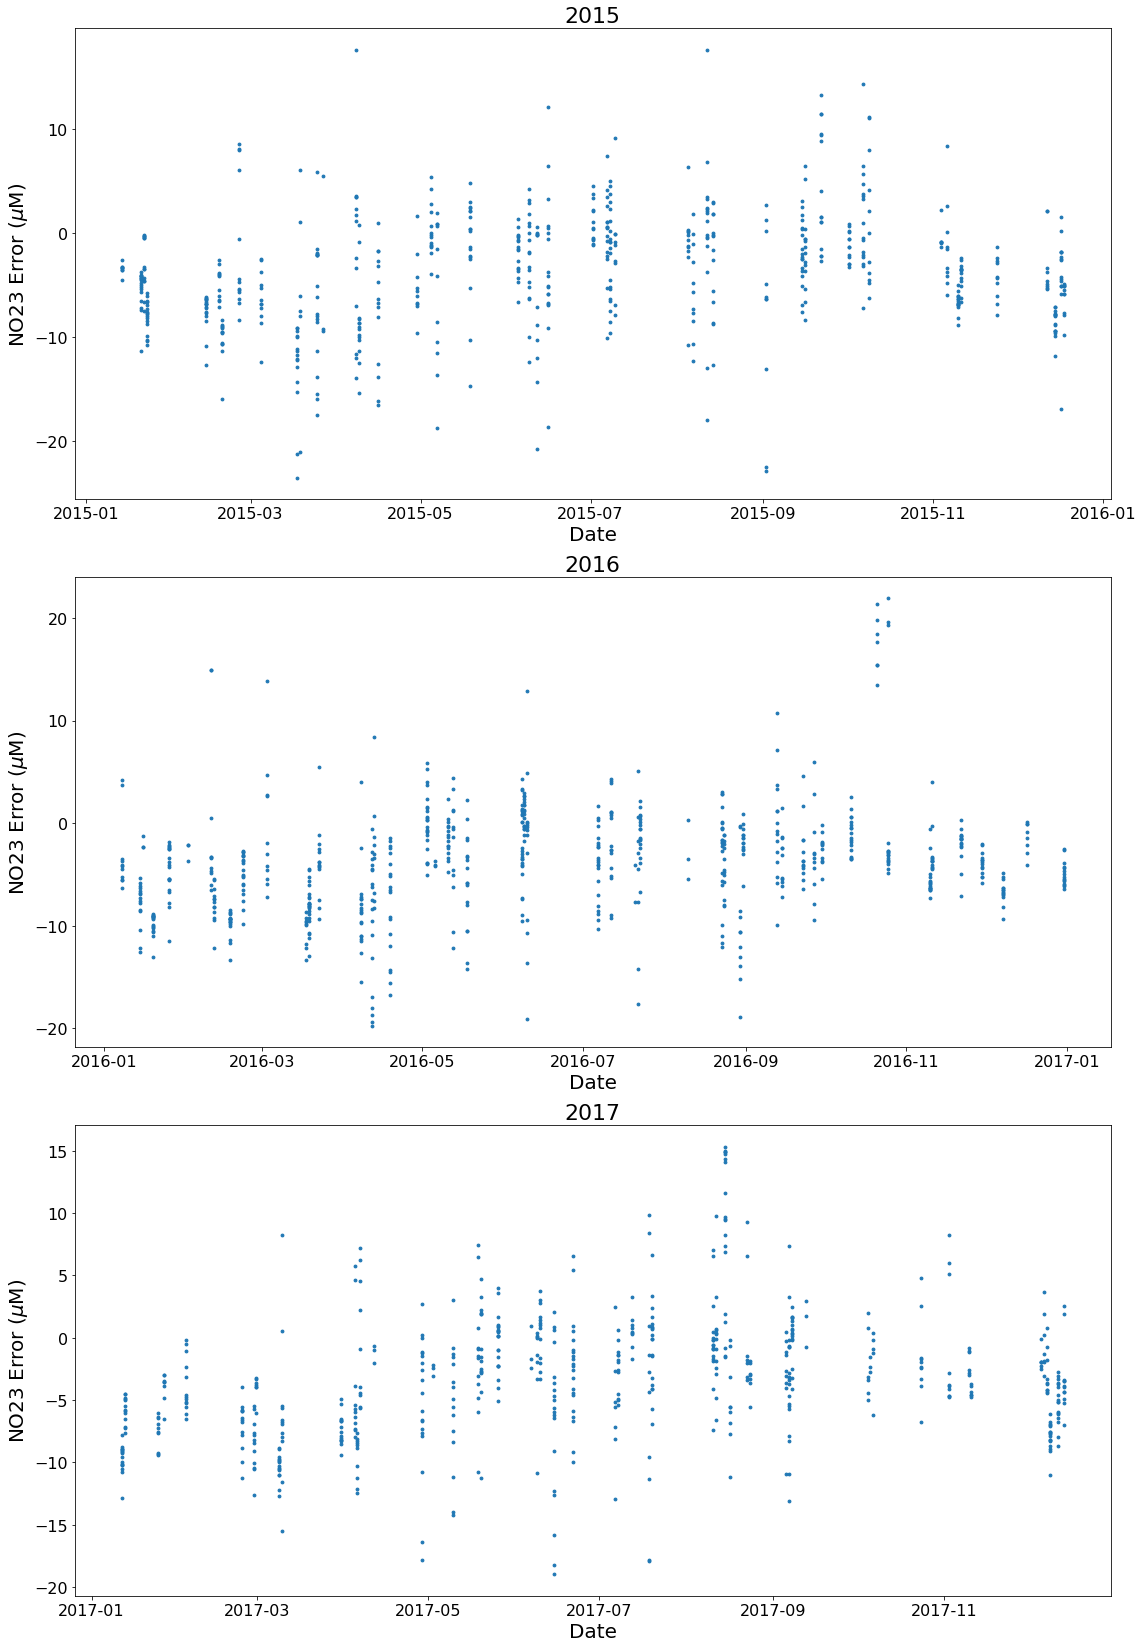

In [28]:
obsvar='NO23'
modvar='mod_nitrate'

multi_timerror_graph(3,(16,23),years,obsvar,modvar)

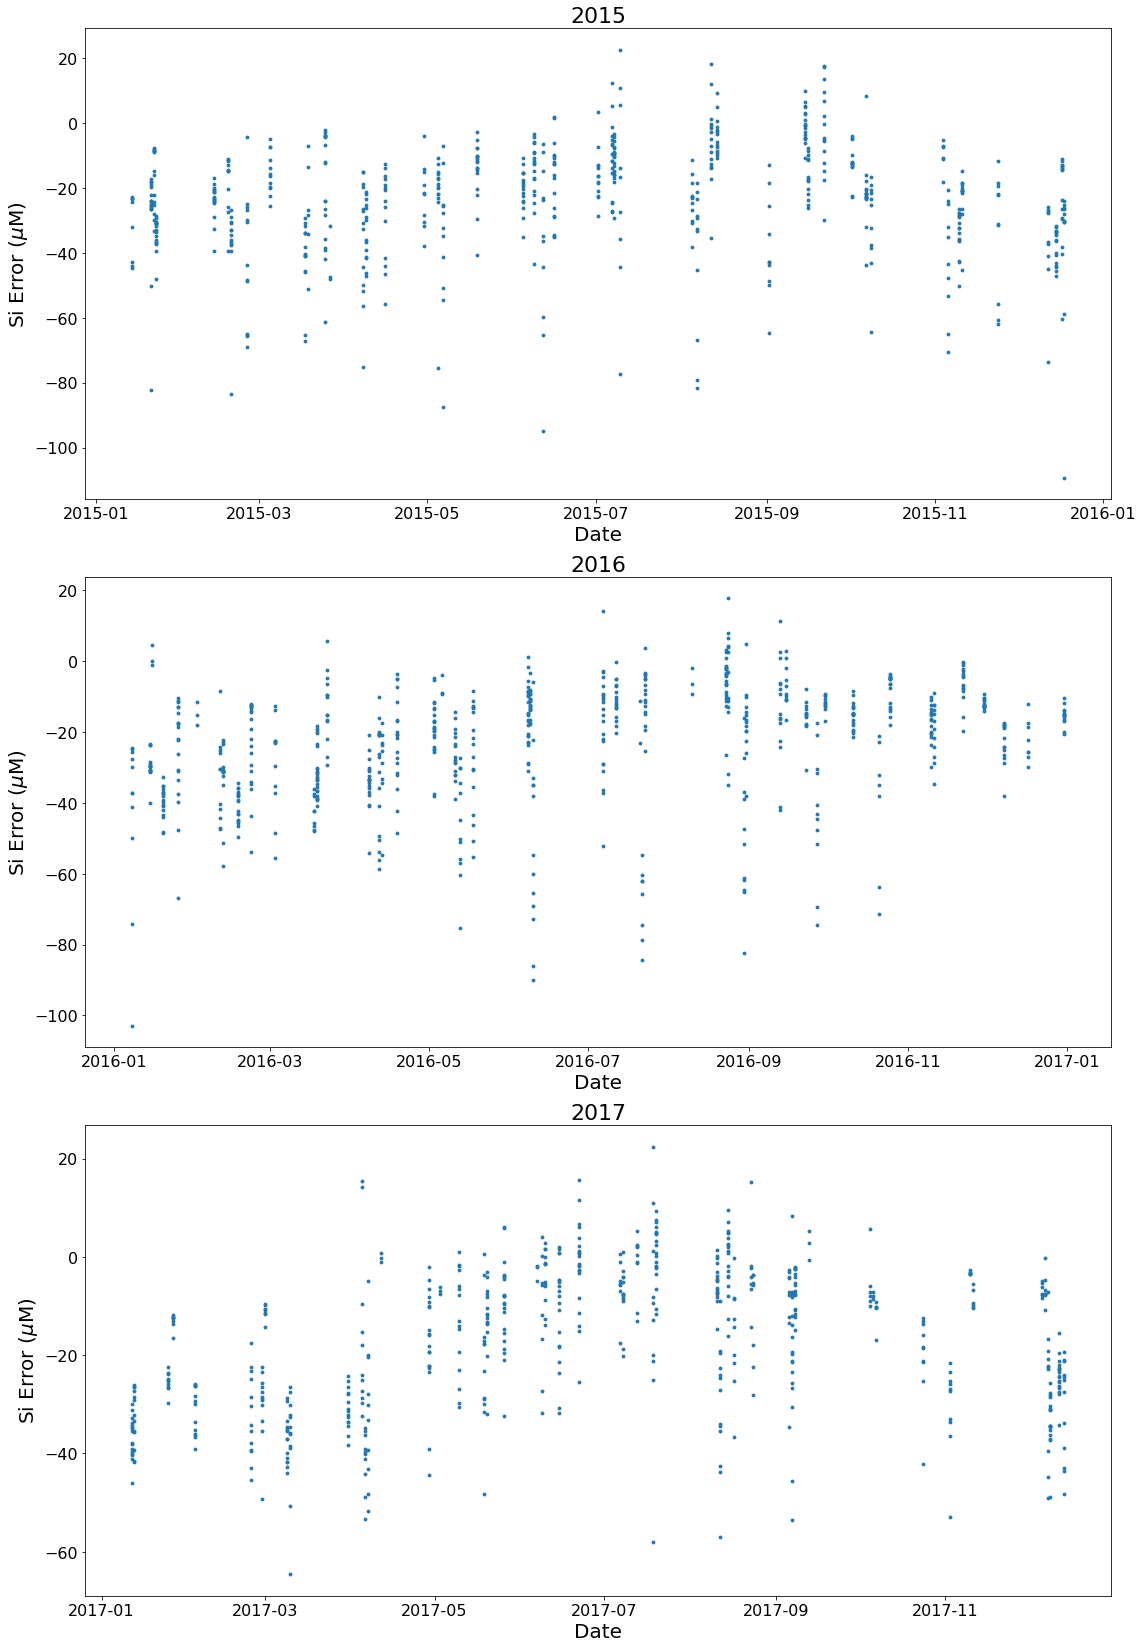

In [29]:
obsvar='Si'
modvar='mod_silicon'

multi_timerror_graph(3,(16,23),years,obsvar,modvar)

In [30]:
def multi_timese_graph(down,figsize,years,obsvar,modvar):
    fig,ax=plt.subplots(down,1,figsize=figsize)
    for d,Y in zip(range(down),years):
            m=ax[d].scatter(datyear[Y]['dtUTC'],datyear[Y][obsvar],s=8,cmap='gnuplot',color='blue')
            m=ax[d].scatter(datyear[Y]['dtUTC'],datyear[Y][modvar],s=8,cmap='gnuplot',color='red') 
            ax[d].set_xlabel(f'Date',fontsize=20)
            ax[d].set_ylabel(f'{obsvar} Error ($\mu$M)',fontsize=20)
            ax[d].set_title(str(Y), fontsize=22)
    plt.tight_layout()

## Observed nitrate and Model nitrate over time

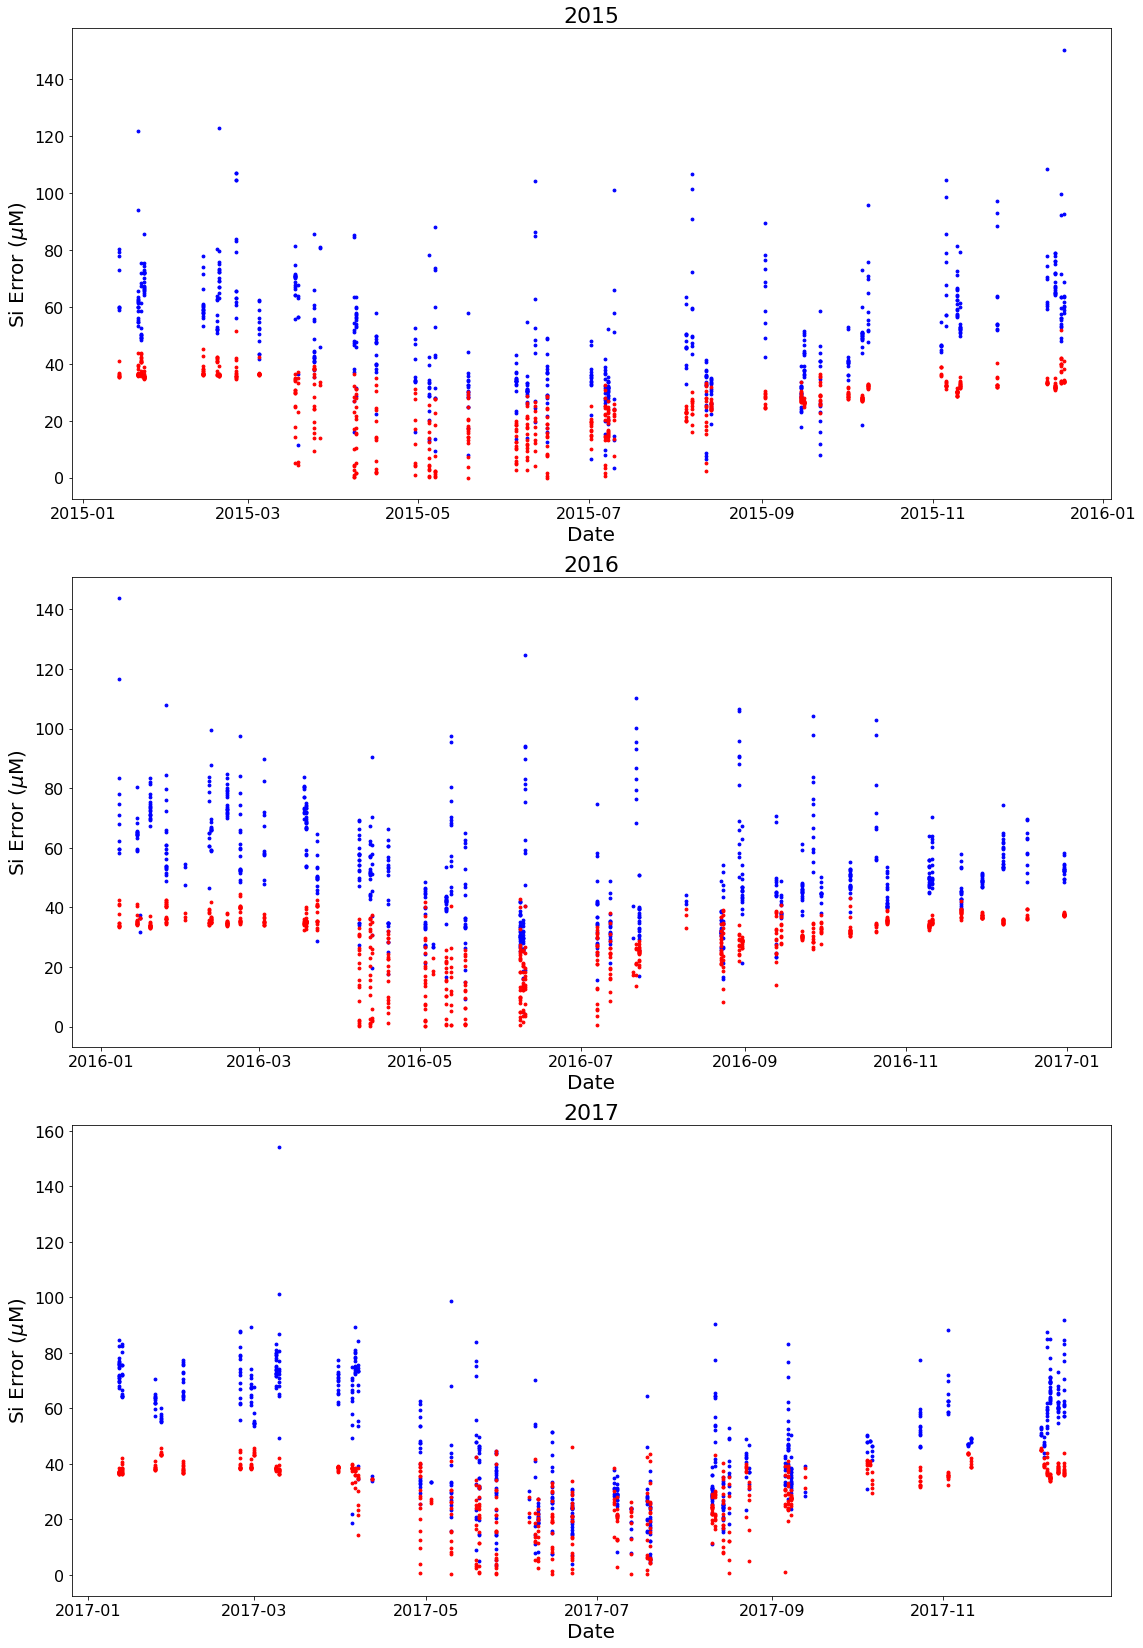

In [31]:
multi_timese_graph(3,(16,23),years,obsvar,modvar)